In [1]:
import scipy, GPy, patsy
from gpmultipy import dataset

In [2]:
%pylab

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [3]:
%matplotlib inline

In [4]:
ds = dataset.DataSet('data/')

# x,y,effect,labels = ds.build(Strain='ura3',scale='range',effects=['Well','Bio','mM_PQ'])
x,y,effect,labels = ds.build(Strain='ura3',scale='range',Bio=['B','C','D'],effects=['Well','Bio','mM_PQ'])

# remove early time points
x = x[6:,:]
y = y[6:,:]

# observations that are on an edge are removed
edge = range(101,111) + range(111,191,10) + range(120,191,10) + range(191,201) + range(201,211) + range(211,291,10) + range(220,291,10) + range(291,301)
edge = np.array(edge)

dist = np.array([min(abs(l-edge)) for l in labels[0]])
position = (dist==0).astype(int)

select = dist > 0
y = y[:,select]
effect = effect.iloc[select,:]

# convert PQ to ratio (need to remove 0 PQ samples)
select = effect.mM_PQ != labels[2].index(0.0)
y = y[:,select]
effect = effect.iloc[select.values,:]

# standardize
y = np.log2(y)

# scale to 0 within bio reps
# for i,p in enumerate(effect.Bio.unique()):
#     select = effect.Bio==p
#     y[:,select] -= y[0,select].mean()

y = (y-y.mean())/y.std()

y.shape

(139, 42)

In [5]:
labels[2]

[0.0,
 0.041500000000000002,
 0.083000000000000004,
 0.16699999999999998,
 0.33299999999999996,
 0.66700000000000004,
 1.3330000000000002]

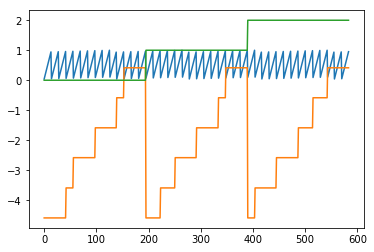

In [6]:
xgp = np.zeros((x.shape[0]*y.shape[1], 3))
xgp[:,0] = np.tile(x[:,0], y.shape[1])
xgp[:,1] = np.repeat(effect.mM_PQ.values,x.shape[0])
xgp[:,2] = np.repeat(effect.Bio.values,x.shape[0])

#replace effect index with actual value
xgp[:,1] = [labels[2][int(i)] for i in xgp[:,1]]
# ratio
xgp[:,1] = np.log2(xgp[:,1])

pqvals = np.unique(xgp[:,1])
pqvals.sort()

ygp = y.ravel(1)[:,None]

# xgp = xgp[:x.shape[0]*15,:]
# ygp = ygp[:x.shape[0]*15,:]

xgp = xgp[::10]
ygp = ygp[::10]

plt.plot(xgp)

In [7]:
kmain = GPy.kern.RBF(2,ARD=True, name='main')
ktech = GPy.kern.RBF(2,ARD=True, name='bio')

k = GPy.kern.Hierarchical([kmain,ktech])
k

hierarchy.,value,constraints,priors
main.variance,1.0,+ve,
main.lengthscale,"(2,)",+ve,
bio.variance,1.0,+ve,
bio.lengthscale,"(2,)",+ve,


In [8]:
m = GPy.models.GPRegression(xgp,ygp,k)
m.randomize()
m

GP_regression.,value,constraints,priors
hierarchy.main.variance,0.52119690206,+ve,
hierarchy.main.lengthscale,"(2,)",+ve,
hierarchy.bio.variance,0.57077831508,+ve,
hierarchy.bio.lengthscale,"(2,)",+ve,
Gaussian_noise.variance,0.426882879538,+ve,


In [9]:
m.optimize()
m

GP_regression.,value,constraints,priors
hierarchy.main.variance,0.879929125564,+ve,
hierarchy.main.lengthscale,"(2,)",+ve,
hierarchy.bio.variance,0.0169964562868,+ve,
hierarchy.bio.lengthscale,"(2,)",+ve,
Gaussian_noise.variance,0.00623911577141,+ve,


In [10]:
m.kern.main.lengthscale

index,GP_regression.hierarchy.main.lengthscale,constraints,priors
[0],0.27150701,+ve,
[1],1.92504979,+ve,


In [11]:
m.kern.bio.lengthscale

index,GP_regression.hierarchy.bio.lengthscale,constraints,priors
[0],0.27512009,+ve,
[1],0.68234681,+ve,


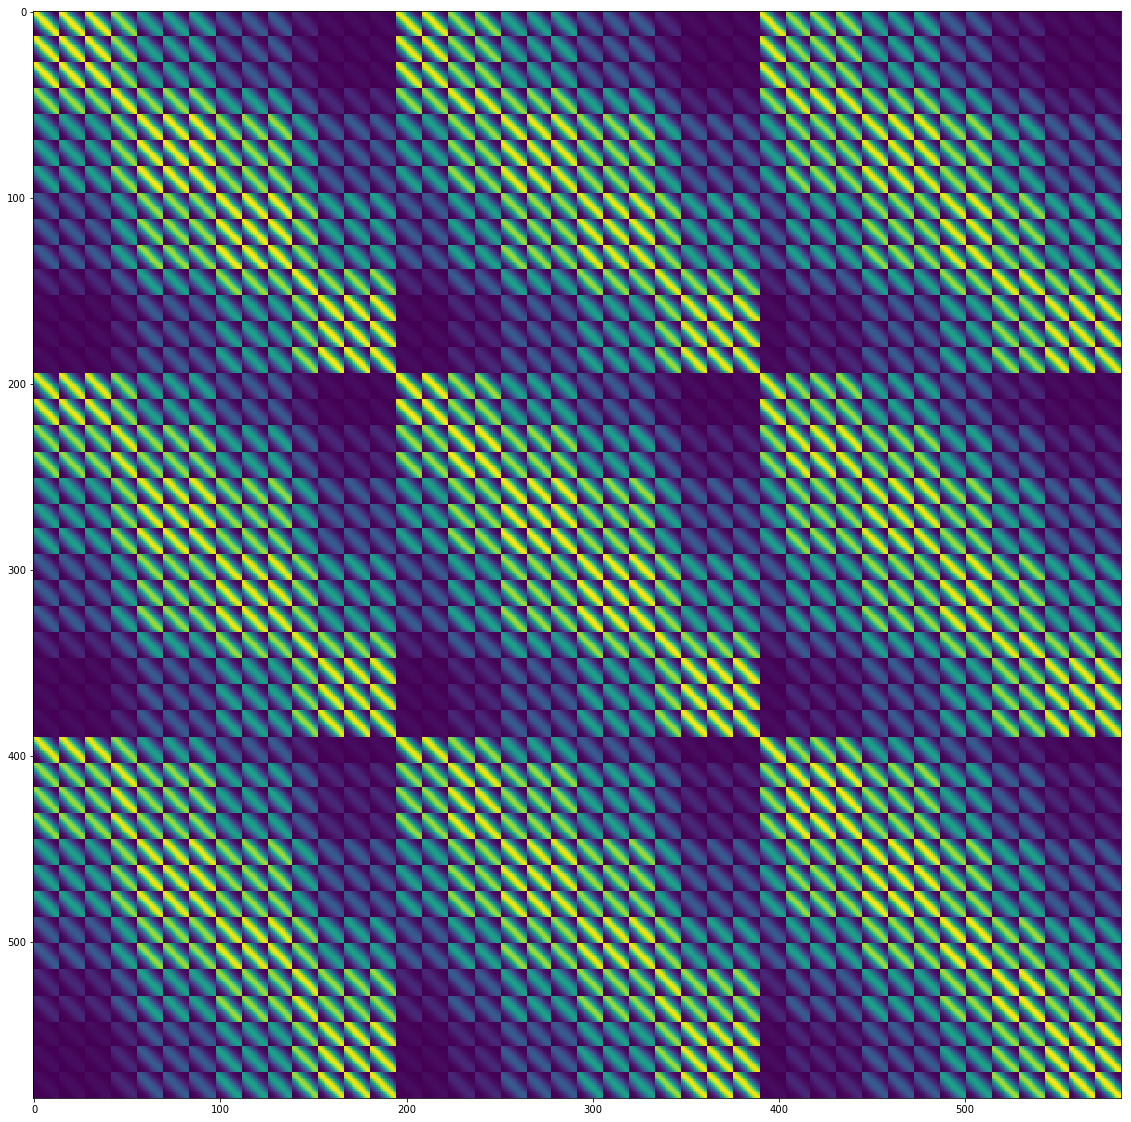

In [12]:
plt.figure(figsize=(20,20))
plt.imshow(k.K(xgp))

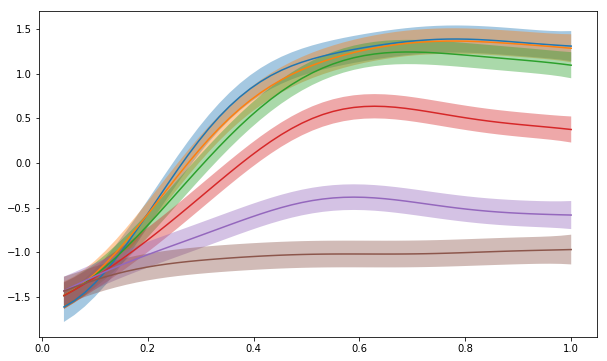

In [13]:
xpred = np.zeros((50*pqvals.shape[0], 3))
xpred[:,0] = np.tile(np.linspace(x.min(),x.max()),pqvals.shape[0])
xpred[:,1] = np.repeat(pqvals,50)
xpred[:,2] = 1000

mu,cov = m.predict_noiseless(xpred,kern=kmain)

mu = mu.reshape(pqvals.shape[0], 50).T
cov = cov.reshape(pqvals.shape[0], 50).T

std = np.sqrt(cov)

plt.figure(figsize=(10,6))
lines = plt.plot(xpred[:50,0], mu)

for i in range(mu.shape[1]):
    plt.fill_between(xpred[:50,0], mu[:,i]-1.96*std[:,i], mu[:,i]+1.96*std[:,i],alpha=.4)

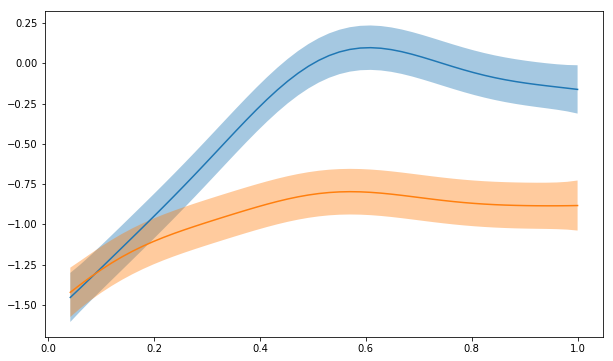

In [14]:
newPqvals = np.array([-1.05, -.08])

xpred = np.zeros((50*newPqvals.shape[0], 3))
xpred[:,0] = np.tile(np.linspace(x.min(),x.max()),newPqvals.shape[0])
xpred[:,1] = np.repeat(newPqvals,50)
xpred[:,2] = 1000

mu,cov = m.predict_noiseless(xpred,kern=kmain)

mu = mu.reshape(newPqvals.shape[0], 50).T
cov = cov.reshape(newPqvals.shape[0], 50).T

std = np.sqrt(cov)

plt.figure(figsize=(10,6))
lines = plt.plot(xpred[:50,0], mu)

for i in range(mu.shape[1]):
    plt.fill_between(xpred[:50,0], mu[:,i]-1.96*std[:,i], mu[:,i]+1.96*std[:,i],alpha=.4)